#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 07
**CH07A Finding a Good Deal among Hotels with Simple Regression**

hotels-vienna  dataset

version 1.0 2021-05-05

In [1]:
%pip install scikit-misc
import os
import sys
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mizani.formatters import percent_format
from plotnine import *
import statsmodels.formula.api as smf

warnings.filterwarnings("ignore")


Note: you may need to restart the kernel to use updated packages.


In [2]:
# load vienna
hotels = pd.read_csv("/workspaces/codespaces-jupyter/data/hotels-vienna.csv")
# hotels = pd.read_csv("https://osf.io/y6jvb/download")
 

### SAMPLE SELECTION

Apply filters:  3-4 stars, Vienna actual, without  extreme value

In [3]:
hotels = hotels.loc[
    (hotels["accommodation_type"] == "Hotel")
    & (hotels["city_actual"] == "Vienna")
    & (hotels["stars"] >= 3)
    & (hotels["stars"] <= 4)
    & (hotels["stars"].notna())
    & (hotels["price"] <= 600)
]
hotels


,country,city_actual,rating_count,center1label,center2label,neighbourhood,price,city,stars,ratingta,...,offer_cat,year,month,weekend,holiday,distance,distance_alter,accommodation_type,nnights,rating
1,Austria,Vienna,189.0,City centre,Donauturm,17. Hernals,81,Vienna,4.0,3.5,...,1-15% offer,2017,11,0,0,1.7,3.8,Hotel,1,3.9
2,Austria,Vienna,53.0,City centre,Donauturm,Alsergrund,85,Vienna,4.0,3.5,...,15-50% offer,2017,11,0,0,1.4,2.5,Hotel,1,3.7
3,Austria,Vienna,55.0,City centre,Donauturm,Alsergrund,83,Vienna,3.0,4.0,...,15-50% offer,2017,11,0,0,1.7,2.5,Hotel,1,4.0
4,Austria,Vienna,33.0,City centre,Donauturm,Alsergrund,82,Vienna,4.0,3.5,...,15-50% offer,2017,11,0,0,1.2,2.8,Hotel,1,3.9
6,Austria,Vienna,57.0,City centre,Donauturm,Alsergrund,103,Vienna,4.0,3.5,...,0% no offer,2017,11,0,0,0.9,2.4,Hotel,1,3.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,Austria,Vienna,77.0,City centre,Donauturm,Wieden,100,Vienna,3.0,4.0,...,1-15% offer,2017,11,0,0,1.2,3.7,Hotel,1,4.0
421,Austria,Vienna,572.0,City centre,Donauturm,Wieden,95,Vienna,4.0,4.0,...,1-15% offer,2017,11,0,0,1.5,3.9,Hotel,1,4.1
422,Austria,Vienna,53.0,City centre,Donauturm,Wieden,73,Vienna,3.0,3.0,...,1-15% offer,2017,11,0,0,1.5,4.0,Hotel,1,3.4
425,Austria,Vienna,112.0,City centre,Donauturm,Wieden,100,Vienna,4.0,4.5,...,0% no offer,2017,11,0,0,1.0,3.7,Hotel,1,4.4


In [4]:
# save a copy of the work file
hotels.to_csv("hotels_work_copy.csv", index=False)


### Summary statistics on price and distance

In [5]:
# Price
hotels[["price"]].describe(percentiles=[0.50, 0.95])


,price
count,207.000000
mean,109.975845
std,42.221381
min,50.000000
50%,100.000000
95%,183.400000
max,383.000000


In [6]:
# Distance
hotels[["rating"]].describe(percentiles=[0.50, 0.95])


,rating
count,207.000000
mean,4.055556
std,0.382195
min,2.200000
50%,4.100000
95%,4.500000
max,4.800000


In [7]:
hotels["rating"].unique()

array([3.9, 3.7, 4. , 4.6, 4.1, 2.7, 4.3, 3.5, 4.4, 4.5, 4.8, 3.2, 3.4,
       2.2, 3. ])

### REGRESSION 1: CLOSE VS FAR REGRESSION WITH BINARY DISTANCE


In [8]:
hotels["rat2"] = hotels["rating"] >= 4.1
hotels["Eprice_cat2"] = hotels.groupby("rat2")["price"].transform("mean")
hotels["Eprice_cat2"].unique()

array([ 92.69607843, 126.76190476])

In [9]:
hotels["rat2"] = hotels["rat2"].replace(False, "Okay")
hotels["rat2"] = hotels["rat2"].replace(True, "Excellent")

In [10]:
hotels[["rat2", "rating", "price"]].groupby("rat2").aggregate("describe")

rating                                               price  \
           count      mean       std  min  25%  50%  75%  max  count   
rat2                                                                   
Excellent  105.0  4.335238  0.183963  4.1  4.1  4.4  4.5  4.8  105.0   
Okay       102.0  3.767647  0.313132  2.2  3.7  3.9  4.0  4.0  102.0   

                                                                     
                 mean        std   min    25%    50%     75%    max  
rat2                                                                 
Excellent  126.761905  38.946592  60.0  99.00  120.0  152.00  242.0  
Okay        92.696078  38.464537  50.0  75.25   84.5  103.75  383.0

# Figure 7.1a
# PLOT MEAN VALUES BY CLOSE VS FAR

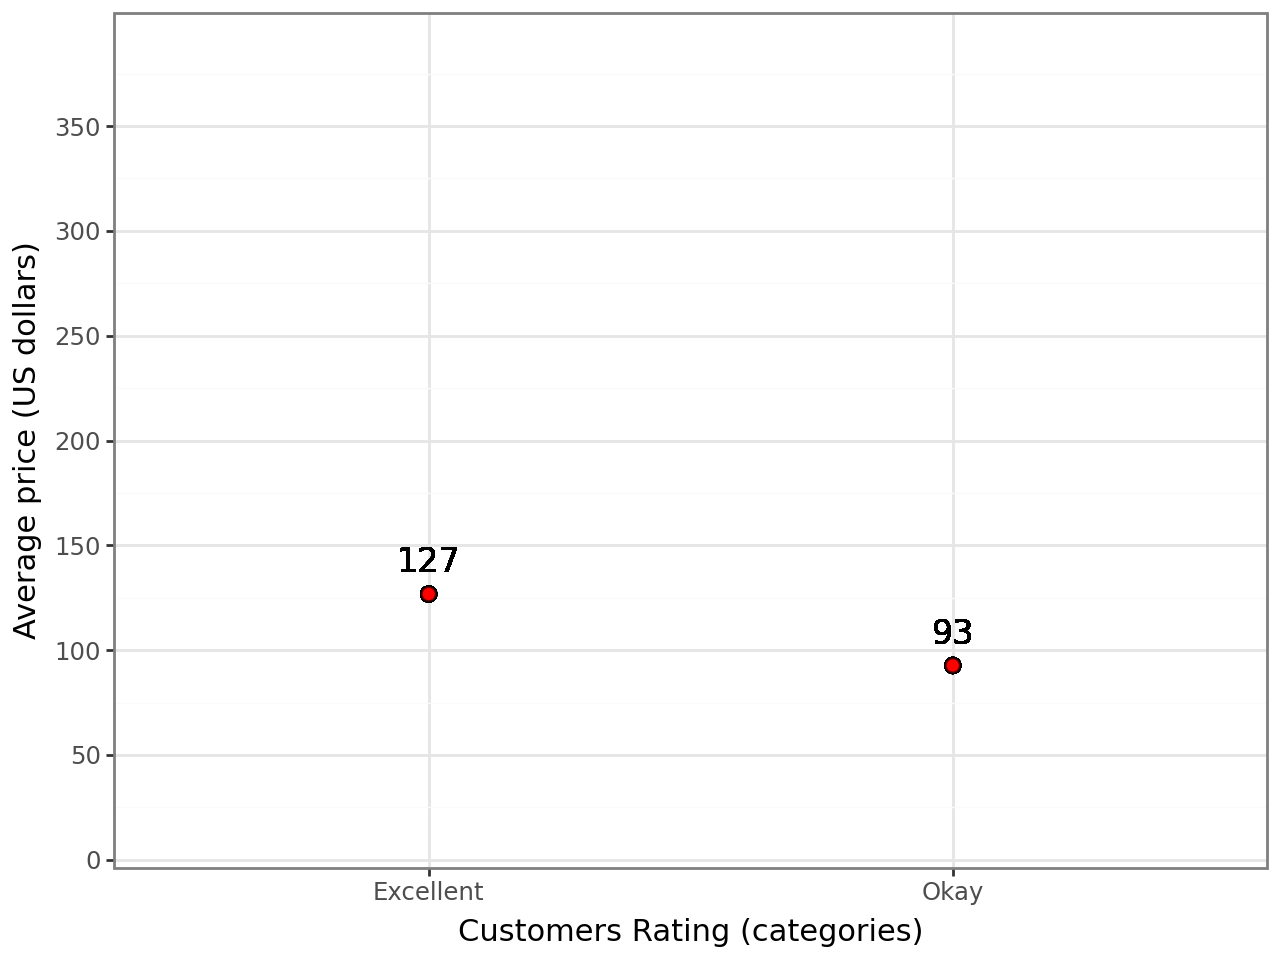

In [11]:
(
    ggplot(hotels)
    + geom_point(
        aes(x="rat2", y="Eprice_cat2"),
        size=2.5,
        color="black",
        fill="red",
        alpha=0.4,
    )
    + geom_text(
        aes(
            x="rat2",
            y="[x+15 for x in Eprice_cat2]",
            label=np.round(hotels.Eprice_cat2).apply(int),
        ),
        color="black",
        size=12,
    )
    + scale_y_continuous(expand=[0.01, 0.01], limits=[0, 400], breaks=np.arange(0, 400, 50))
    + expand_limits(y=0.01)
    + scale_x_discrete()
    + labs(x="Customers Rating (categories)", y="Average price (US dollars)")
    + theme_bw()
)


In [30]:
def bin_rating(x):
    if x < 3.0:
        return 1
    elif x < 3.5:
        return 2
    elif x < 4.0:
        return 3
    else:
        return 4

hotels['rat4'] = hotels['rating'].apply(bin_rating)

In [32]:
hotels["rat4"]

1      3
2      3
3      4
4      3
6      3
      ..
420    4
421    4
422    2
425    4
426    2
Name: rat4, Length: 207, dtype: int64

In [33]:
hotels.groupby("rat4")["price"].describe()

,count,mean,std,min,25%,50%,75%,max
rat4,,,,,,,,
1,3.0,82.000000,4.358899,77.0,80.50,84.0,84.50,85.0
2,6.0,73.666667,19.663842,54.0,59.25,68.0,85.75,104.0
3,55.0,87.145455,27.650208,50.0,69.50,81.0,99.00,223.0
4,143.0,120.867133,43.449864,60.0,88.50,112.0,141.00,383.0


In [34]:
hotels["Eprice_cat4"] = hotels.groupby("rat4")["price"].transform("mean")

In [35]:
hotels[["rat4", "distance", "price"]].groupby("rat4").aggregate("describe")


distance                                                    price  \
        count      mean       std  min    25%   50%    75%  max  count   
rat4                                                                     
1         3.0  2.600000  1.609348  0.8  1.950  3.10  3.500  3.9    3.0   
2         6.0  1.716667  1.441411  0.7  1.025  1.25  1.475  4.6    6.0   
3        55.0  1.801818  1.184700  0.2  0.900  1.50  2.050  4.8   55.0   
4       143.0  1.395105  1.114079  0.0  0.600  1.10  1.850  6.6  143.0   

                                                                
            mean        std   min    25%    50%     75%    max  
rat4                                                            
1      82.000000   4.358899  77.0  80.50   84.0   84.50   85.0  
2      73.666667  19.663842  54.0  59.25   68.0   85.75  104.0  
3      87.145455  27.650208  50.0  69.50   81.0   99.00  223.0  
4     120.867133  43.449864  60.0  88.50  112.0  141.00  383.0

In [36]:
a=hotels["rat4"].unique()
for d in a:
    mean_price = hotels.loc[hotels["rat4"] == d, "Eprice_cat4"].iloc[0]
    print(f"rat4 = {d}: Eprice_cat4 = {mean_price}")


rat4 = 3: Eprice_cat4 = 87.14545454545454
rat4 = 4: Eprice_cat4 = 120.86713286713287
rat4 = 1: Eprice_cat4 = 82.0
rat4 = 2: Eprice_cat4 = 73.66666666666667


In [37]:
hotels["rating"]

1      3.9
2      3.7
3      4.0
4      3.9
6      3.9
      ... 
420    4.0
421    4.1
422    3.4
425    4.4
426    3.2
Name: rating, Length: 207, dtype: float64

In [44]:
import pandas as pd

# Assume you already have your hotels DataFrame with a 'distance' and 'price' column

# Step 1: Define bins and assign them
bins = [2.4, 3.1, 4.1, 4.3, float('inf')]
labels = ['bin1', 'bin2', 'bin3', 'bin4']
hotels['bin'] = pd.cut(hotels['rating'], bins=bins, labels=labels, right=False)

# Step 2: Define the midpoints of each bin
bin_midpoints = {
    'bin1': 2.4,
    'bin2': 3.1,
    'bin3': 4.1,
    'bin4': 4.3  # authors used 5.0 as midpoint for the last wider bin
}

# Step 3: Compute average price in each bin
avg_prices = hotels.groupby('bin')['price'].mean()
avg_prices = avg_prices.reindex(labels)  # keep bin order

# Step 4: Compute slopes between adjacent bins
slopes = []
slope_sum = 0
n = 0
#weights = []
slope_weighted_sum = 0
weight_sum = 0

for i in range(len(labels) - 1):
    bin_a = labels[i]
    bin_b = labels[i + 1]
    
    x1 = bin_midpoints[bin_a]
    x2 = bin_midpoints[bin_b]
    
    y1 = avg_prices[bin_a]
    y2 = avg_prices[bin_b]
    
    slope = round((y2 - y1) / (x2 - x1), 0)
    slopes.append(slope)
    slope_sum += slope 
    n += 1
    width = slope / slope_sum  # this is the weight: slope divided by total of all slopes
    slope_weighted_sum += slope * width
    weight_sum += width

# Output

w=0
s=0
sum_w=0

for i, slope in enumerate(slopes):
    
    print(f"Slope between {labels[i]} and {labels[i+1]}: {slope}")
    
    w = float(slope/slope_sum)
    print(f"Weight:{w}")
    sum_w += w
    
    a=slope*w
    print(f"Up:{a}")
    
    print()
    s += a
   # print(width)
    u =round(slope_sum / n, 0)
    w =round(slope_weighted_sum / weight_sum, 0)


print(f"Unweighted Avg:{round(slope_sum/n,0)}")
print(s)
print(sum_w)
print(f"Weighted Avg:{round(s/sum_w,0)}")

#print(w)
#print(slope_weighted_sum)
#print(weight_sum)


Slope between bin1 and bin2: 13.0
Weight:0.10569105691056911
Up:1.3739837398373984

Slope between bin2 and bin3: 21.0
Weight:0.17073170731707318
Up:3.5853658536585367

Slope between bin3 and bin4: 89.0
Weight:0.7235772357723578
Up:64.39837398373984

Unweighted Avg:41.0
69.35772357723577
1.0
Weighted Avg:69.0


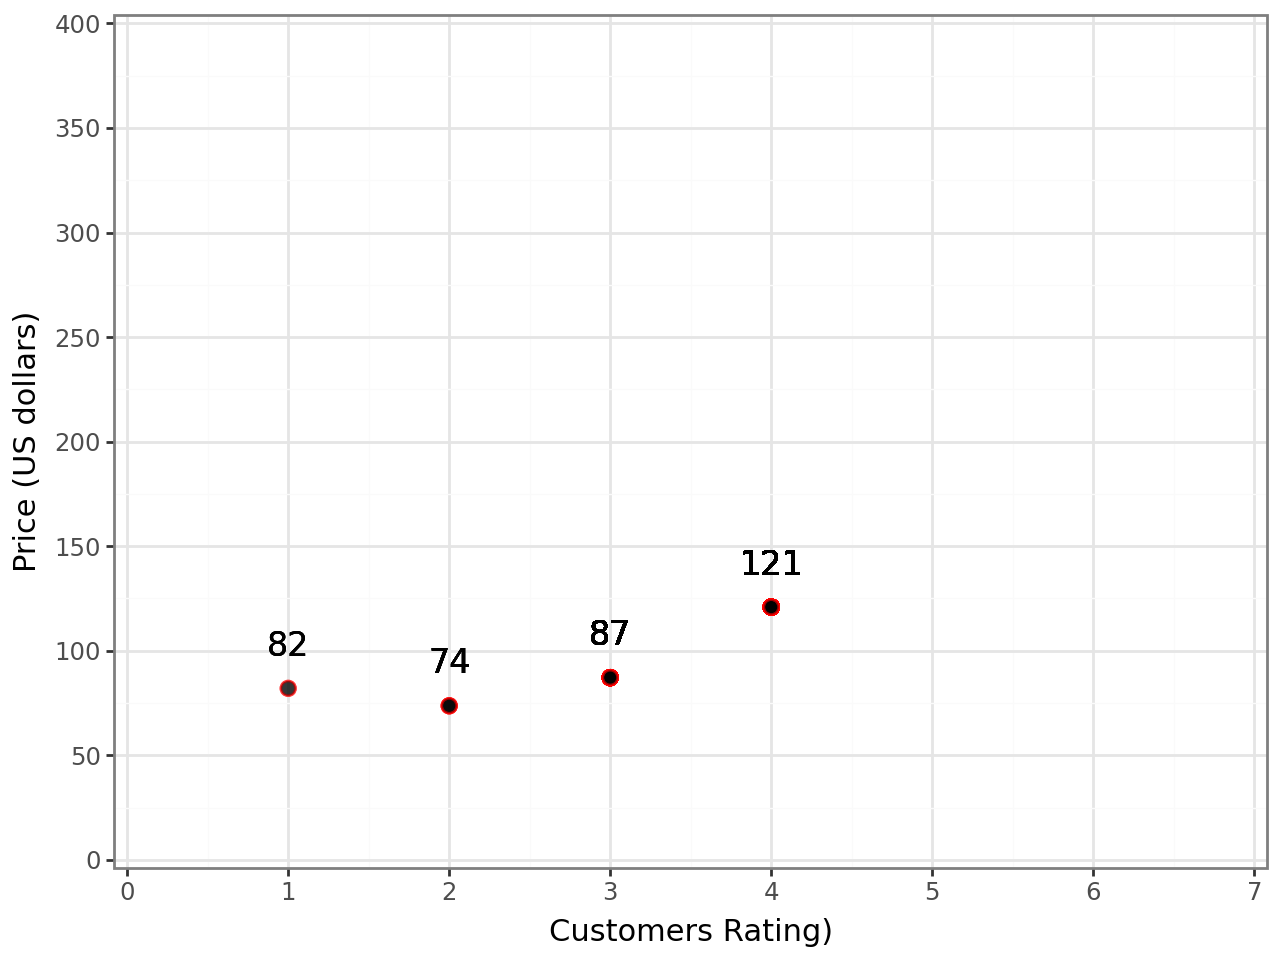

In [45]:
(
    ggplot(data=hotels)
    + geom_point(
        aes(x="rat4", y="Eprice_cat4"),
        size=2.5,
        color="red",
        fill="black",
        alpha=0.4,
    )
    + geom_text(
        aes(
            x="rat4",
            y="[x+20 for x in Eprice_cat4]",
            label=np.round(hotels.Eprice_cat4).apply(int),
        ),
        color="black",
        size=12,
    )
    + expand_limits(x=0.01, y=0.01)
    + coord_cartesian(xlim=[0, 7], ylim=[0, 400])
    + scale_y_continuous(expand=[0.01, 0.01], limits=[0, 400], breaks=np.arange(0, 401, 50))
    + scale_x_continuous(
        expand=[0.01, 0.01], limits=[0, 7], breaks=[0, 1, 2, 3, 4, 5, 6, 7]
    )
    + labs(x="Customers Rating)", y="Price (US dollars)")
    + theme_bw()
)


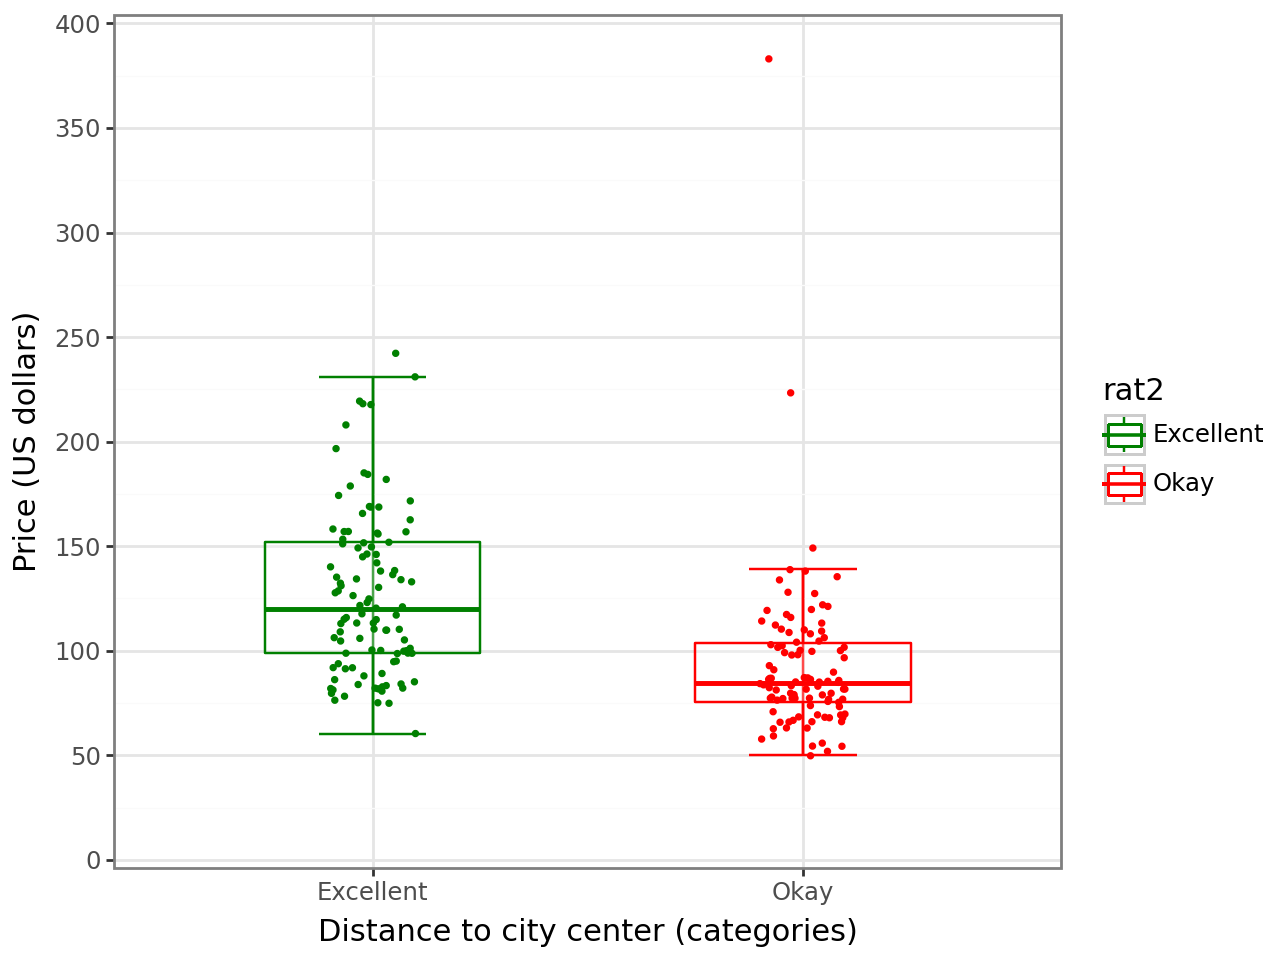

In [50]:
(
    ggplot(hotels, aes(x="rat2", y="price"))
    + stat_boxplot(
        aes(group="rat2", color="rat2"), geom="errorbar", width=0.25, size=0.5
    )
    + geom_boxplot(
        aes(group="rat2", color="rat2"),
        size=0.5,
        width=0.5,
        alpha=0.3,
        outlier_color="",  # to hide outliers
    )
    + geom_jitter(
        aes(color="rat2"), position=position_jitter(0.1), size=0.5, show_legend=False
    )
    + scale_color_manual(values=["green", "red"])
    + labs(x="Distance to city center (categories)", y="Price (US dollars)")
    + scale_y_continuous(expand=[0.01, 0.01], limits=[0, 400], breaks=np.arange(0, 401, 50))
    + expand_limits(y=0.01)
    + theme_bw()
)

In [52]:
hotels[hotels["price"] > 350]

,country,city_actual,rating_count,center1label,center2label,neighbourhood,price,city,stars,ratingta,...,distance,distance_alter,accommodation_type,nnights,rating,rat2,Eprice_cat2,rat4,Eprice_cat4,bin
247,Austria,Vienna,122.0,City centre,Donauturm,Margareten,383,Vienna,3.0,4.0,...,1.9,4.7,Hotel,1,4.0,Okay,92.696078,4,120.867133,bin2



## FIGURE 7.2a 7.2b

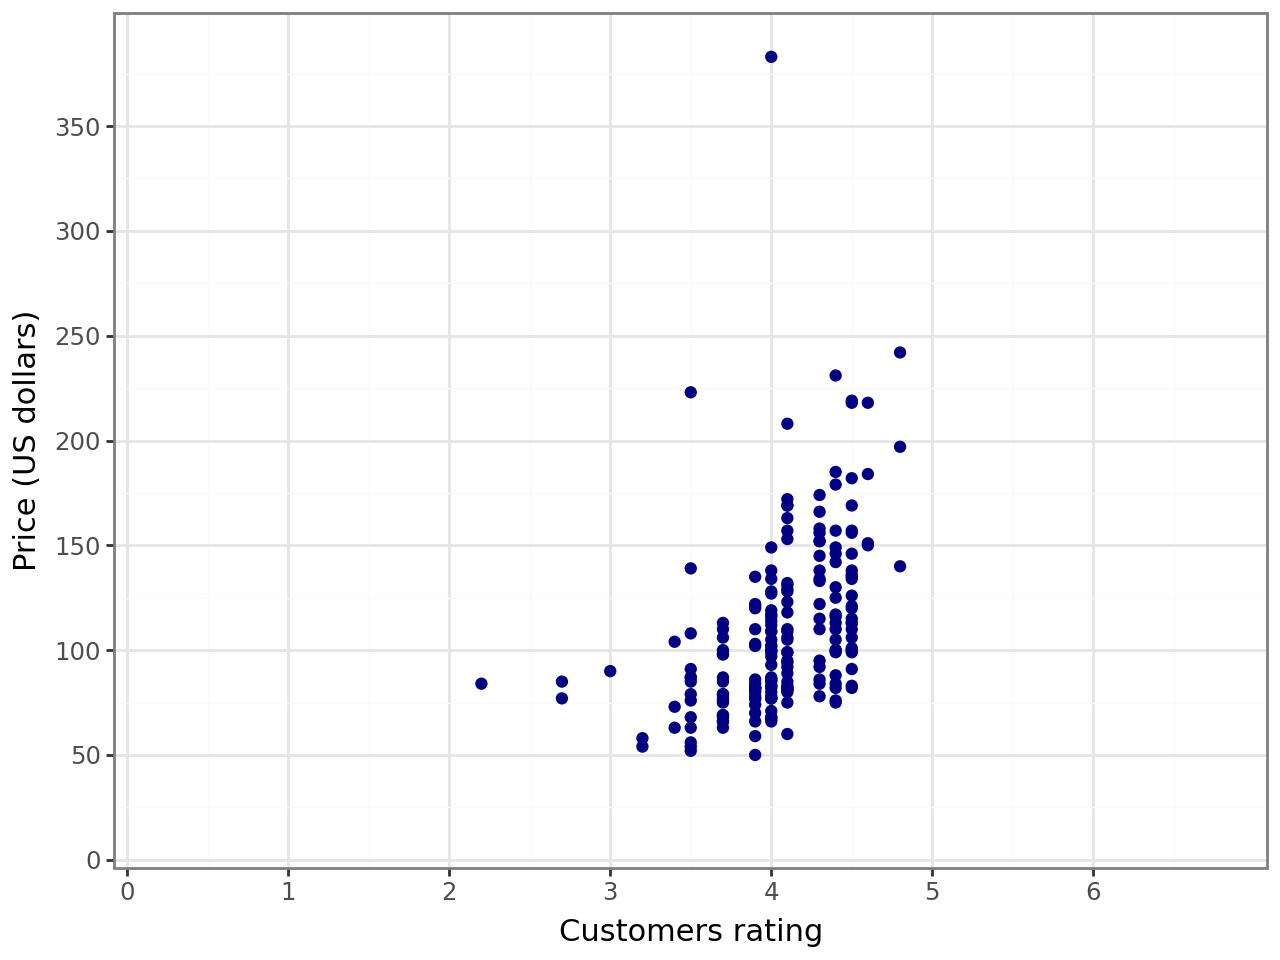

In [53]:
p1 = (
    ggplot(hotels, aes(x="rating", y="price"))
    + geom_point(color="navy")
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(expand=[0.01, 0.01], limits=[0, 7], breaks=np.arange(0, 7, 1))
    + scale_y_continuous(expand=[0.01, 0.01], limits=[0, 400], breaks=np.arange(0, 400, 50))
    + labs(x="Customers rating", y="Price (US dollars)")
    + theme_bw()
)
p1.show()

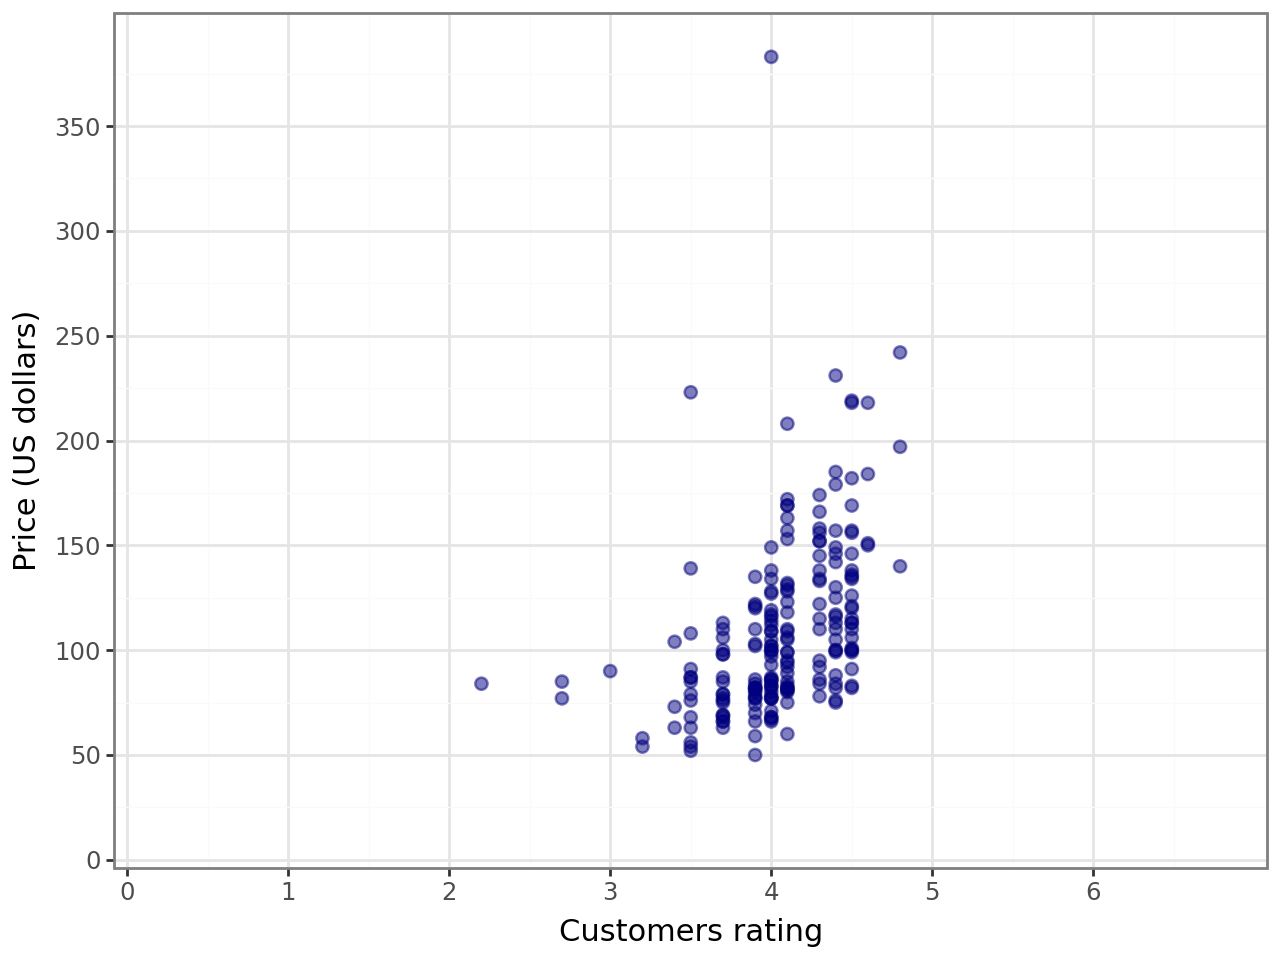

In [56]:
# large sized graphs
(
    ggplot(hotels)
    + geom_point(
        aes(x="rating", y="price"),
        color="navy",
        size=2,
        alpha=0.5,
        show_legend=False,
        na_rm=True,
    )
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(expand=[0.01, 0.01], limits=[0, 7], breaks=np.arange(0, 7, 1))
    + scale_y_continuous(expand=[0.01, 0.01], limits=[0, 400], breaks=np.arange(0, 400, 50))
    + labs(x="Customers rating", y="Price (US dollars)")
    + theme_bw()
)


In [81]:
labels = [1, 2, 3, 4, 5, 6, 7]
hotels['bin_rating_s'] = pd.qcut(hotels['rating'], q=7, labels=labels)

hotels["xend"] = hotels["bin_rating_s"]
hotels["yend"] = hotels["Eprice_cat4"]


hotels["Eprice_cat4"]

1       87.145455
2       87.145455
3      120.867133
4       87.145455
6       87.145455
          ...    
420    120.867133
421    120.867133
422     73.666667
425    120.867133
426     73.666667
Name: Eprice_cat4, Length: 207, dtype: float64

#### Scatterplot with step function (we use 1km bits for simpplicity using 4 bits for 3-7km)


In [82]:
F07_2a = p1 + geom_segment(
    hotels,
    aes("rating", "yend", xend="xend", yend="yend"),
    color="green",
    size=0.7,
    na_rm=True,
)
F07_2a.show()





TypeError: Invalid comparison between dtype=category and int

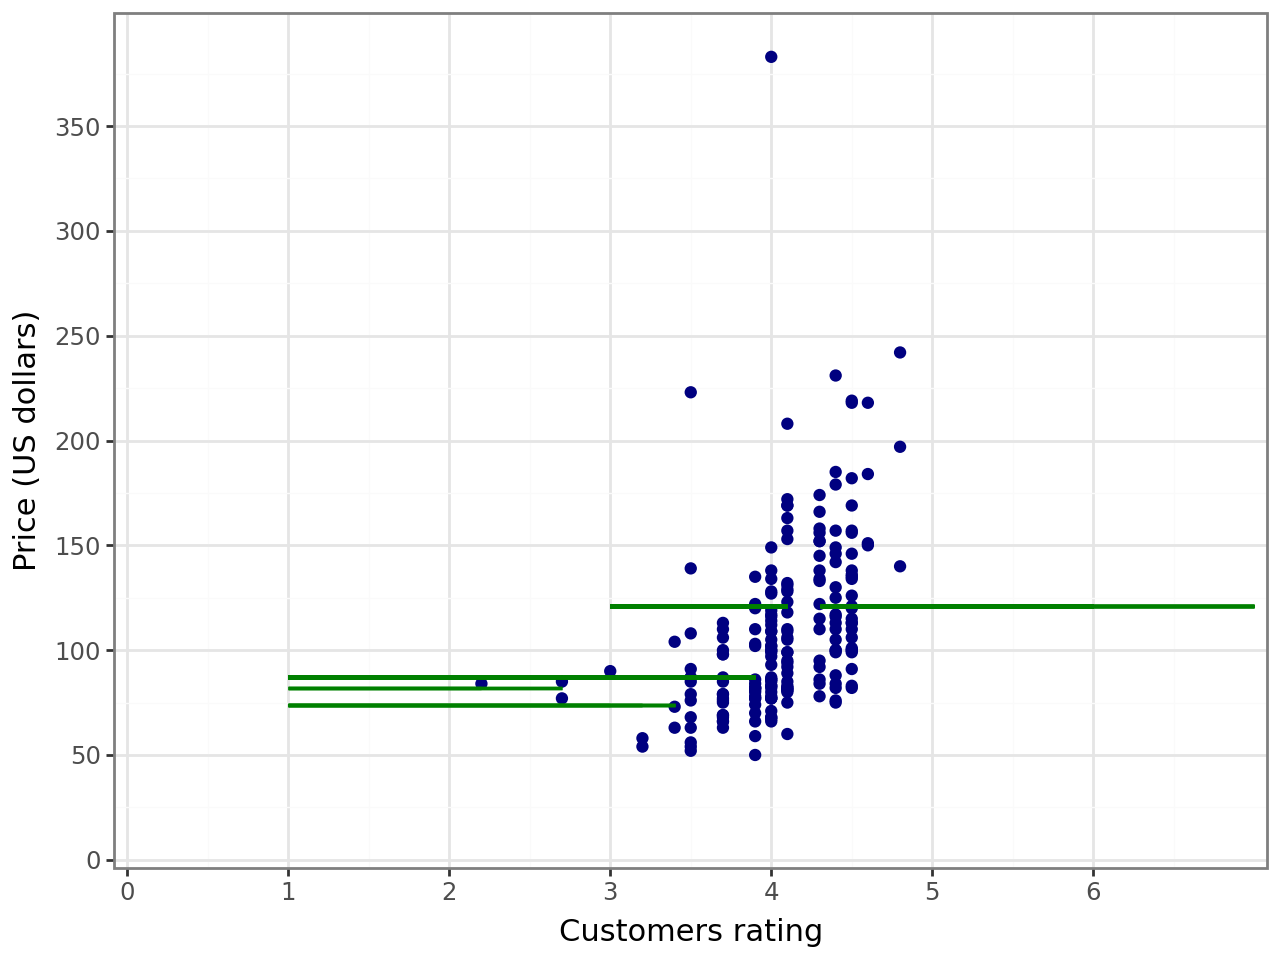

In [83]:
hotels["xend_num"] = pd.to_numeric(hotels["xend"], errors="coerce")

F07_2a = p1 + geom_segment(
    hotels,
    aes(x="rating", y="yend", xend="xend_num", yend="yend"),
    color="green",
    size=0.7,
    na_rm=True,
)
F07_2a.show()

In [84]:
hotels["Eprice_cat7_new"] = hotels.groupby("dist7_new")["price"].transform("mean")

KeyError: 'dist7_new'

In [28]:
hotels[["dist7_new", "distance", "price"]].groupby("dist7_new").aggregate("describe")


distance                                                   price  \
             count      mean       std  min    25%   50%    75%  max count   
dist7_new                                                                    
1.5           81.0  0.554321  0.282865  0.0  0.300  0.60  0.800  0.9  81.0   
2.5           76.0  1.464474  0.294258  1.0  1.200  1.50  1.700  1.9  76.0   
3.5           22.0  2.354545  0.318818  2.0  2.100  2.30  2.600  2.9  22.0   
4.5           20.0  3.525000  0.298901  3.0  3.275  3.60  3.700  3.9  20.0   
5.5            6.0  4.383333  0.292689  4.1  4.125  4.35  4.575  4.8   6.0   
6.5            1.0  5.300000       NaN  5.3  5.300  5.30  5.300  5.3   1.0   
7.5            1.0  6.600000       NaN  6.6  6.600  6.60  6.600  6.6   1.0   

                                                                       
                 mean        std    min     25%    50%     75%    max  
dist7_new                                                              
1.5        132.913580  38.540627   68.0  110.00  128.0  152.00  242.0  
2.5         98.855263  40.893261   54.0   81.75   91.5  105.25  383.0  
3.5         97.545455  40.385909   54.0   76.25   82.5  100.75  208.0  
4.5         80.650000  23.154572   50.0   67.50   77.5   85.50  156.0  
5.5         82.500000  13.619838   68.0   74.75   78.5   87.50  106.0  
6.5        102.000000        NaN  102.0  102.00  102.0  102.00  102.0  
7.5        130.000000        NaN  130.0  130.00  130.0  130.00  130.0

In [29]:
# Scatterplot with step function, starting point is simply at cut-off
hotels["dist7_s"] = hotels.distance.apply(
    lambda x: 1 * int(x >= 1)
    + 1 * int(x >= 2)
    + 1 * int(x >= 3)
    + 1 * int(x >= 4)
    + 1 * int(x >= 5)
    + 1 * int(x >= 6)
    + 1 * int(x >= 7)
)
hotels["xend"] = hotels["dist7_s"] + 1
hotels["yend"] = hotels["Eprice_cat7_new"]


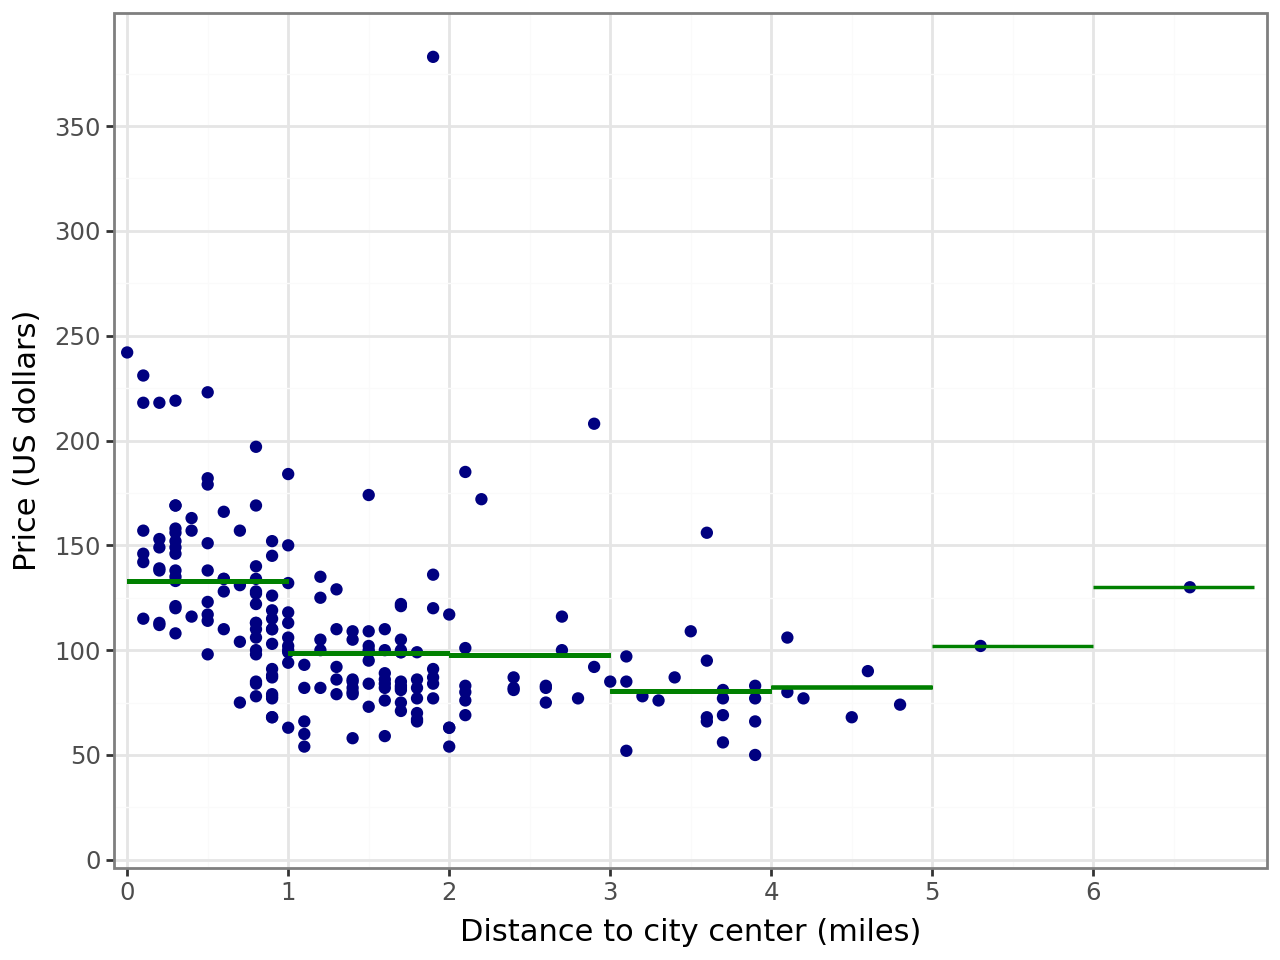

In [30]:
F07_2b = p1 + geom_segment(
    hotels,
    aes(x="dist7_s", y="yend", xend="xend", yend="yend"),
    color="green",
    size=0.7,
    na_rm=True,
)
F07_2b.show()


# Figure 7.3
### LOWESS NONPARAMETRIC REGRESSION

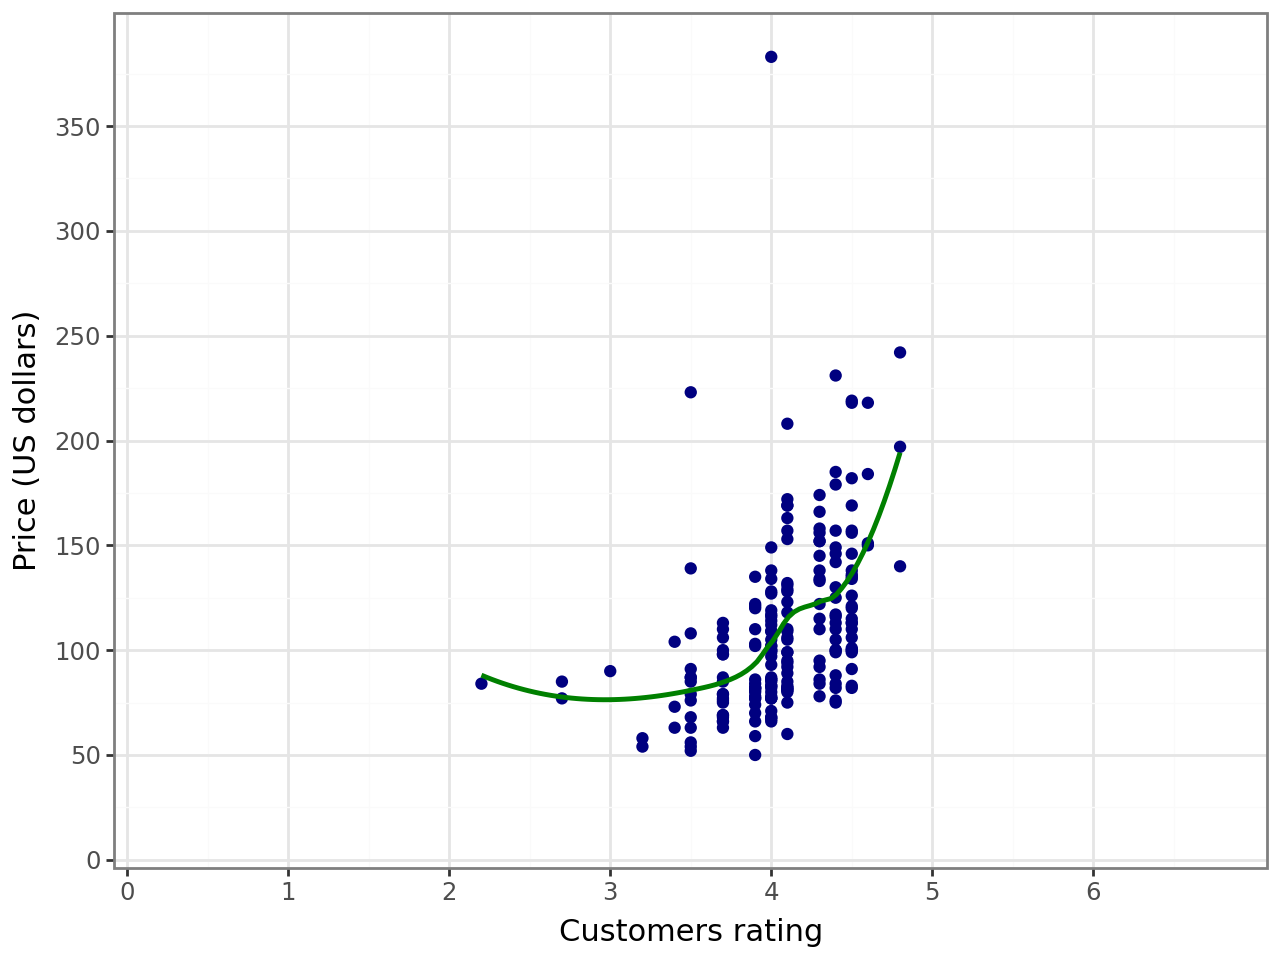

In [85]:
F07_3 = p1 + geom_smooth(method="loess", color="green", se=False)
F07_3.show()


In [87]:
### LINEAR REGRESSIONS
regression = smf.ols(formula="price~rating", data=hotels).fit()
regression.summary()
# regression.summary(slim=True)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     48.42
Date:                Fri, 27 Jun 2025   Prob (F-statistic):           4.54e-11
Time:                        23:50:08   Log-Likelihood:                -1046.1
No. Observations:                 207   AIC:                             2096.
Df Residuals:                     205   BIC:                             2103.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -85.8640     28.267     -3.038      0.003    -141.596     -30.132
rating        48.2893      6.939      6.959      0.000      34.607      61.971
==============================================================================
Omnibus:                      144.815   Durbin-Watson:                   1.420
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1701.529
Skew:                           2.536   Prob(JB):                         0.00
Kurtosis:                      16.098   Cond. No.                         46.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [88]:
### LINEAR REGRESSIONS
regression_r = smf.ols(formula="price~rating_count", data=hotels).fit()
regression_r.summary()
# regression.summary(slim=True)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.764
Date:                Fri, 27 Jun 2025   Prob (F-statistic):              0.186
Time:                        23:50:10   Log-Likelihood:                -1067.1
No. Observations:                 207   AIC:                             2138.
Df Residuals:                     205   BIC:                             2145.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      106.0490      4.162     25.481      0.000      97.843     114.255
rating_count     0.0189      0.014      1.328      0.186      -0.009       0.047
==============================================================================
Omnibus:                      116.368   Durbin-Watson:                   1.304
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              779.201
Skew:                           2.103   Prob(JB):                    6.29e-170
Kurtosis:                      11.524   Cond. No.                         415.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Figure 7.5
### SCATTERPLOT + REGRESSION LINE

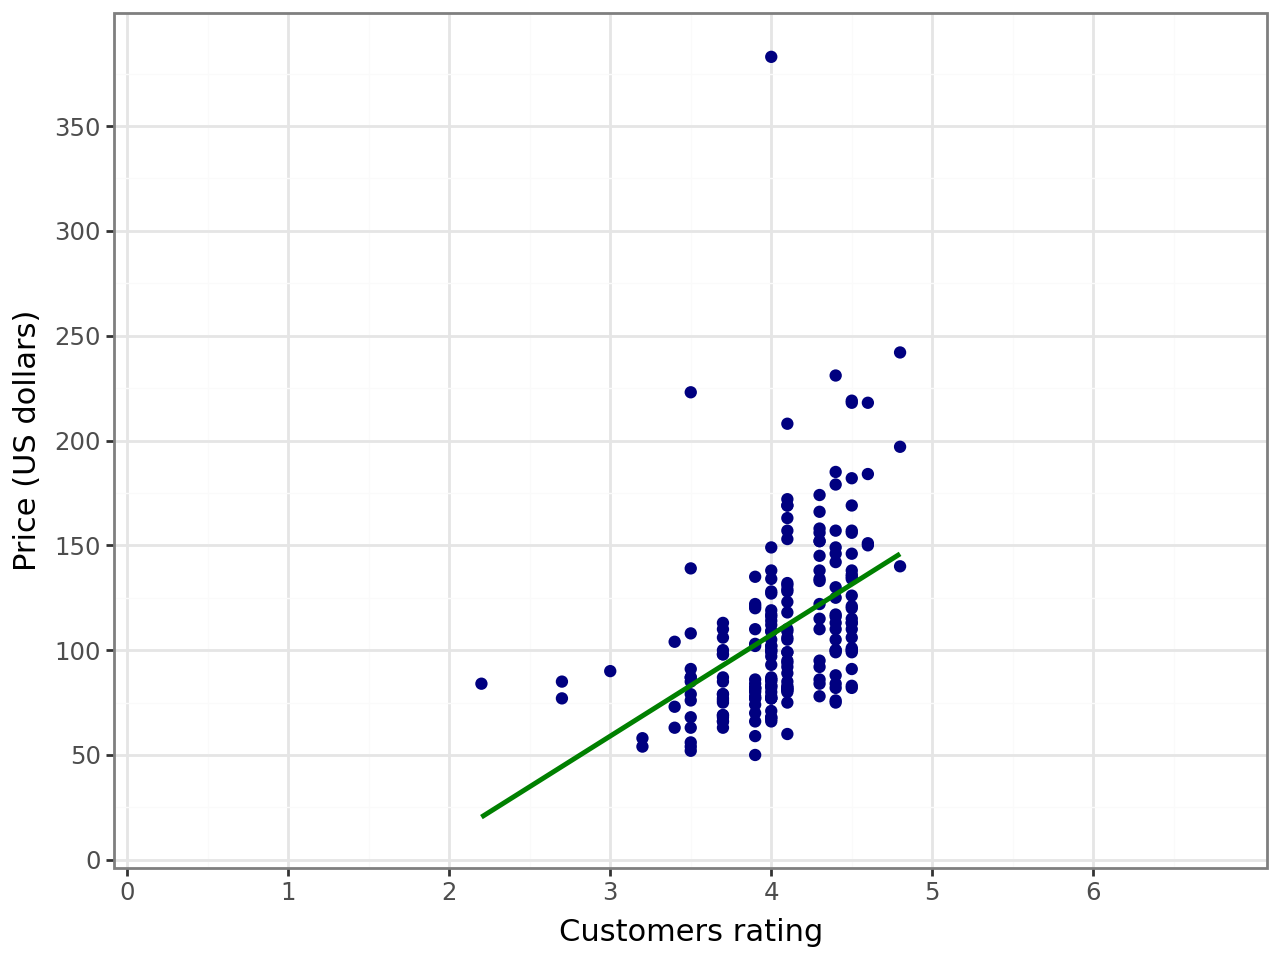

In [89]:
F07_5 = p1 + geom_smooth(method="lm", color="green", se=False)
F07_5.show()


### THE LINEAR REGRESSION GOES THROUGH THE AVERAGES
### SCATTERPLOT + REGRESSION LINE + LINES FOR AVERAGES (NOT in BOOK)

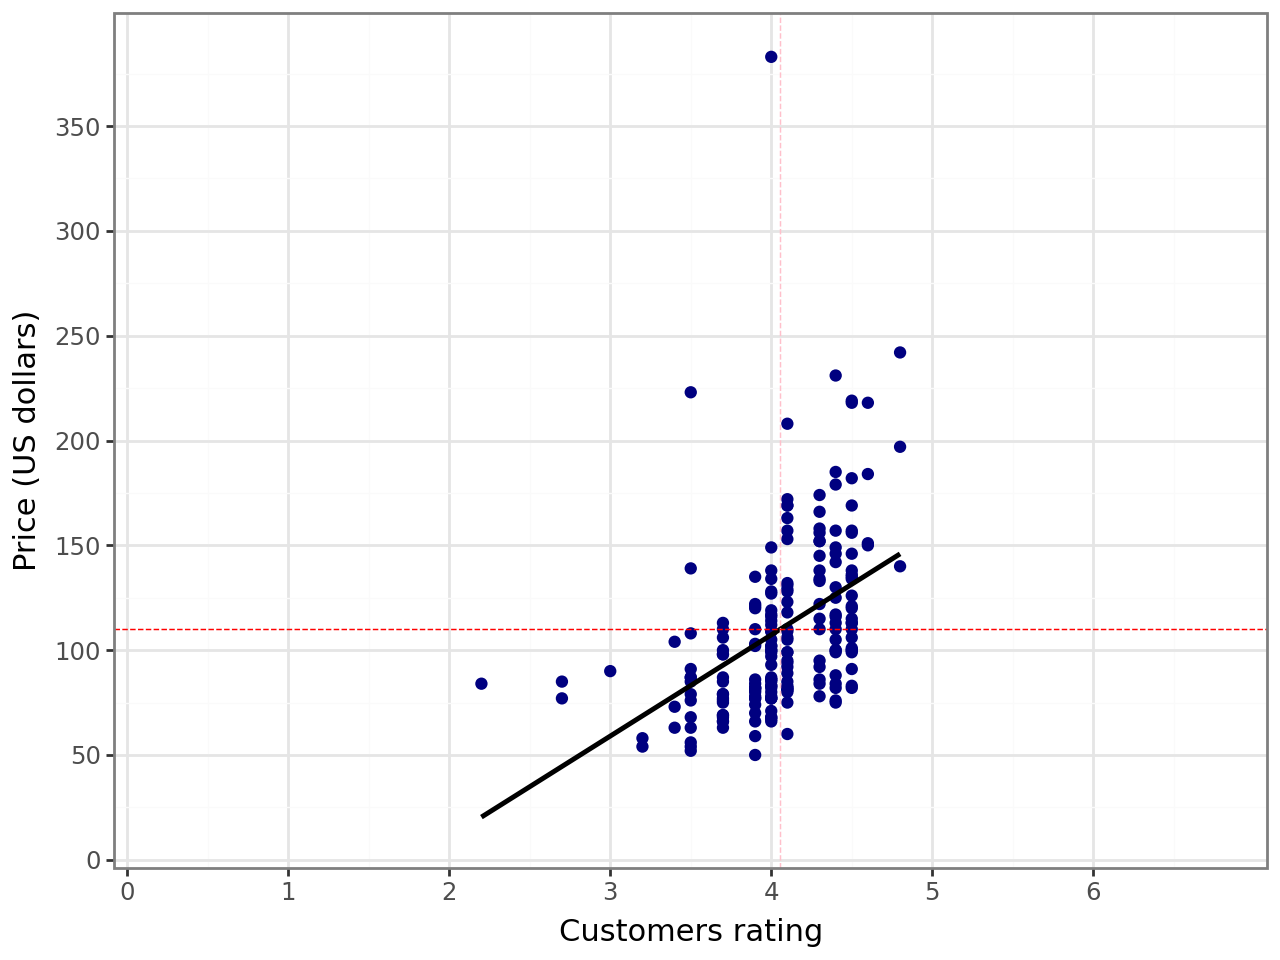

In [90]:
F07_x5 = (
    p1
    + geom_smooth(method="lm", color="black", se=False)
    + geom_vline(
        xintercept=hotels["rating"].mean(),
        color="pink",
        linetype="dashed",
        size=0.3,
    )
    + geom_hline(
        yintercept=hotels["price"].mean(), color="red", linetype="dashed", size=0.3
    )
)
F07_x5.show()


### PREDICTED VALUES & RESIDUALS OF LINEAR REGRESSION 

In [92]:
# OLS for distance & price

regression = smf.ols(formula="price~rating", data=hotels).fit()

hotels["predprice"] = regression.predict()
hotels["e"] = regression.resid

### Figure 7.6, Table 7.1

Pick one observation, with distance = 2.9, and label the residual on the scatter plot

In [93]:
xa = 4.1 # rating

#get annotation values from the dataframe
ya = hotels.loc[hotels["rating"] == xa, "price"].values[0]
ym = hotels.loc[hotels["rating"] == xa, "predprice"].values[0]

xar = 2.9 # distance

#get annotation values from the dataframe
yar = hotels.loc[hotels["distance"] == xar, "rating_count"].values[0]
ymr = hotels.loc[hotels["distance"] == xar, "predratcount"].values[0]

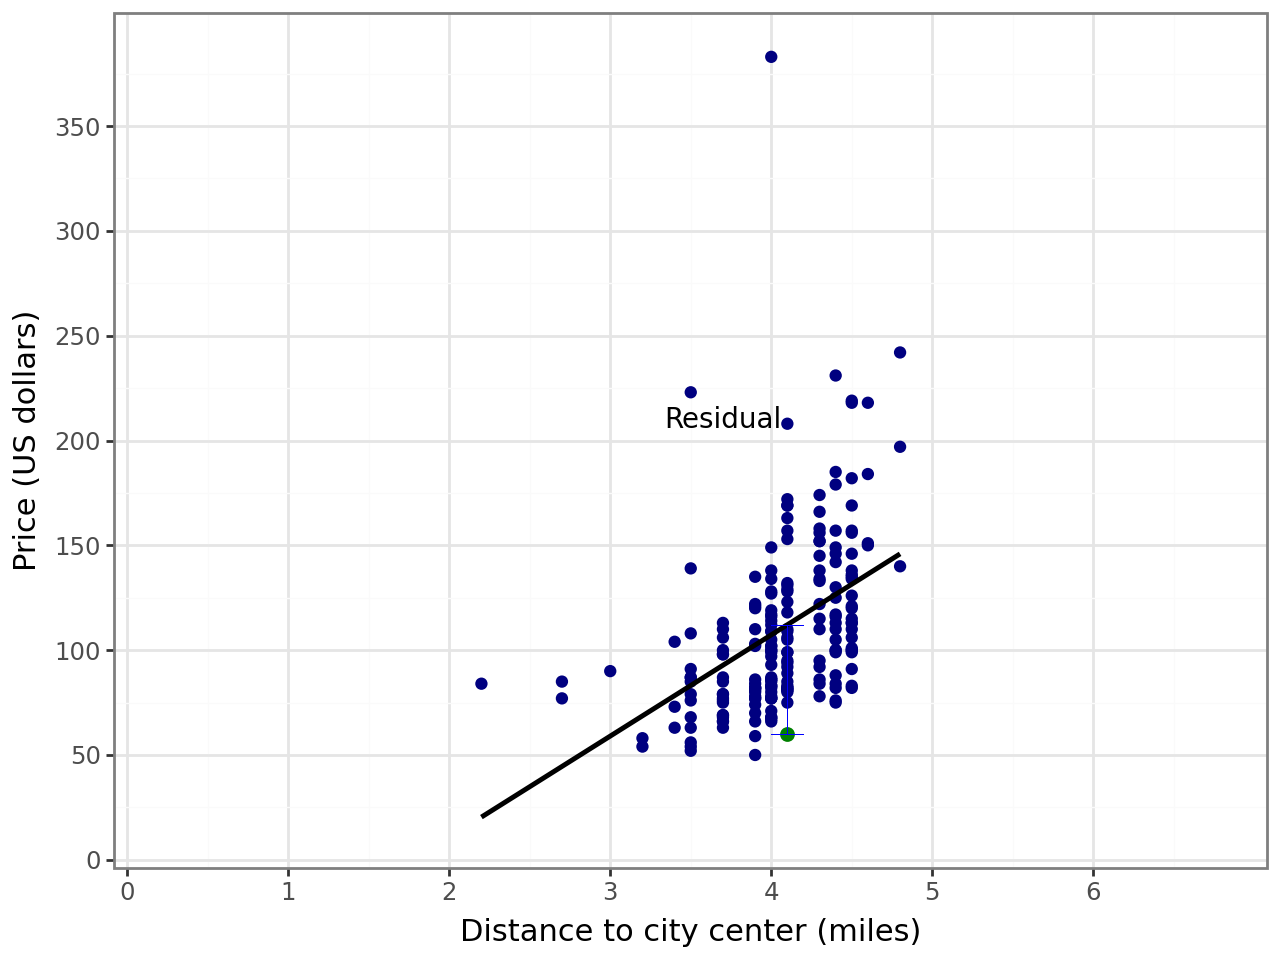

In [94]:
(
    p1
    + geom_smooth(method="lm", color="black", se=False)
    + annotate(
        "text",
        x=3.7,
        y=210,
        label="Residual",
        size=10,
    )
    + annotate("pointrange", x=xa, y=ya, ymin=ya, ymax=ya, color="green", size=0.5)
    + geom_errorbar(
        hotels.loc[hotels["rating"] == xa],
        aes(x="rating", ymin=ym, ymax=ya),
        width=0.2,
        size=0.2,
        color="blue",
    )
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 7), breaks=np.arange(0, 7,1))
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(0, 400), breaks=np.arange(0, 400,50)
    )
    + labs(x="Distance to city center (miles)", y="Price (US dollars)")
    + theme_bw()
)

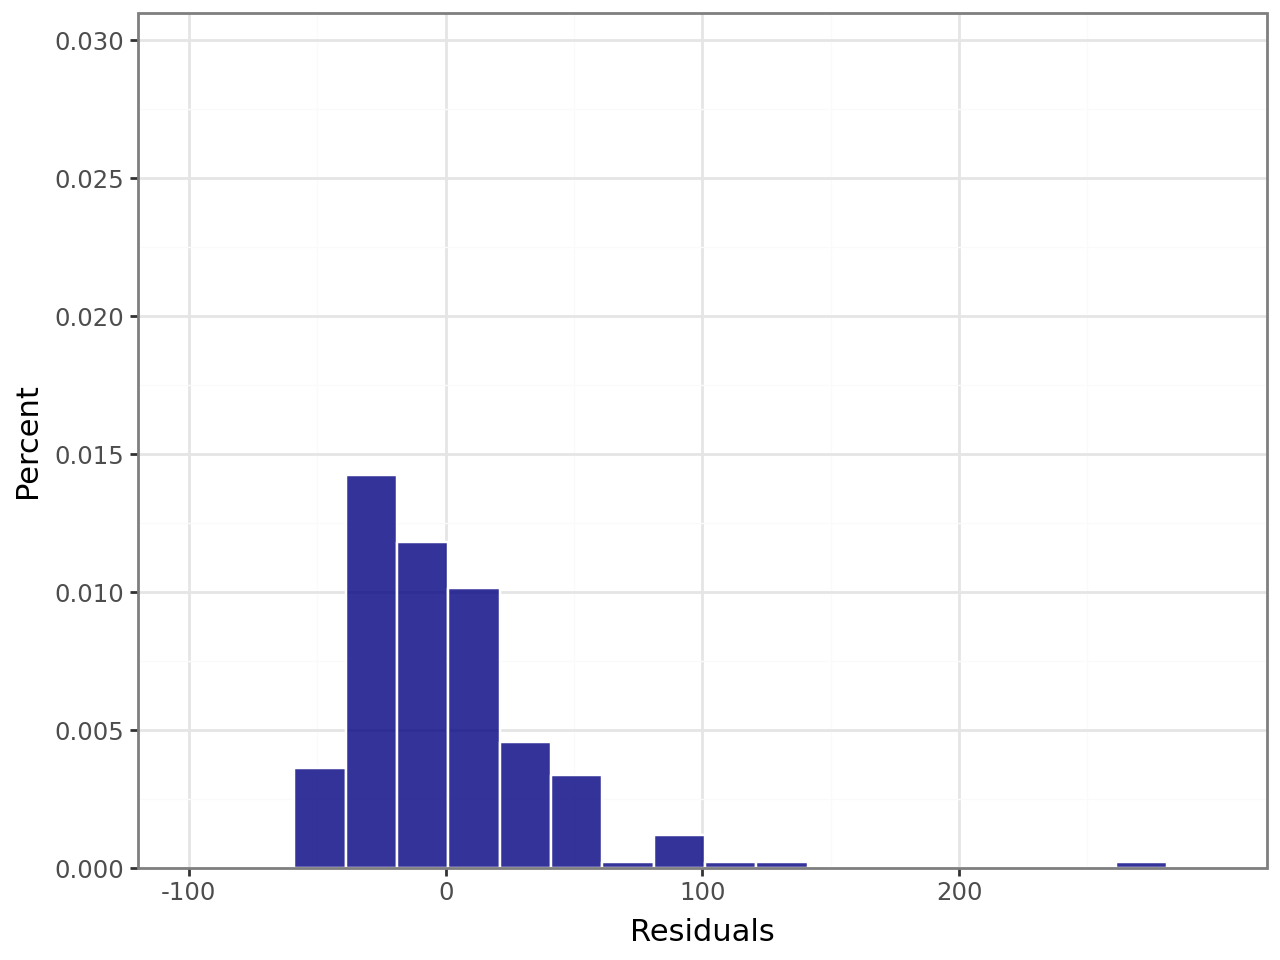

In [95]:
F07_6b = (
    ggplot(hotels, aes(x="e"))
    + geom_histogram(
        aes(y=after_stat('density')),
        binwidth=20,
        boundary=1,
        fill="navy",
        color="white",
        alpha=0.8,
        show_legend=False,
        na_rm=True,
    )
    + labs(x="Residuals", y="Percent")
    + scale_x_continuous(limits=(-100, 300), breaks=np.arange(-100, 300, 100))
    + scale_y_continuous(
        expand=(0, 0),
        limits=(0, 0.031),
        breaks=np.arange(0, 0.031, 0.005)
    )
    + theme_bw()
)
F07_6b.show()


In [96]:
hotels["reg1_res"] = ["overpriced" if e >= 0 else "underpriced" for e in hotels["e"]]


In [97]:
hotels.loc[hotels["e"].sort_values().tail().index, "reg1_res"] = "top5"
hotels.loc[hotels["e"].sort_values().head().index, "reg1_res"] = "bottom5"


In [98]:
hotels_top = hotels[hotels["reg1_res"] == "top5"]
hotels_top

,country,city_actual,rating_count,center1label,center2label,neighbourhood,price,city,stars,ratingta,...,rat4,Eprice_cat4,bin,bin_rating_s,xend,yend,xend_num,predprice,e,reg1_res
26,Austria,Vienna,178.0,City centre,Donauturm,Donaustadt,208,Vienna,4.0,4.0,...,4,120.867133,bin3,4,4,120.867133,4,112.122035,95.877965,top5
110,Austria,Vienna,56.0,City centre,Donauturm,Innere Stadt,231,Vienna,4.0,4.5,...,4,120.867133,bin4,6,6,120.867133,6,126.608816,104.391184,top5
128,Austria,Vienna,404.0,City centre,Donauturm,Innere Stadt,242,Vienna,4.0,4.5,...,4,120.867133,bin4,7,7,120.867133,7,145.924524,96.075476,top5
129,Austria,Vienna,123.0,City centre,Donauturm,Innere Stadt,223,Vienna,4.0,3.5,...,3,87.145455,bin2,1,1,87.145455,1,83.148473,139.851527,top5
247,Austria,Vienna,122.0,City centre,Donauturm,Margareten,383,Vienna,3.0,4.0,...,4,120.867133,bin2,3,3,120.867133,3,107.293108,275.706892,top5


In [99]:
hotels_bottom = hotels[hotels["reg1_res"] == "bottom5"]
hotels_bottom.sort_values(by="e", ascending=True)

,country,city_actual,rating_count,center1label,center2label,neighbourhood,price,city,stars,ratingta,...,rat4,Eprice_cat4,bin,bin_rating_s,xend,yend,xend_num,predprice,e,reg1_res
374,Austria,Vienna,50.0,City centre,Donauturm,Vienna,50,Vienna,3.0,4.0,...,3,87.145455,bin2,2,2,87.145455,2,102.464181,-52.464181,bottom5
10,Austria,Vienna,203.0,City centre,Donauturm,Alsergrund,60,Vienna,4.0,4.0,...,4,120.867133,bin3,4,4,120.867133,4,112.122035,-52.122035,bottom5
35,Austria,Vienna,1122.0,City centre,Donauturm,Favoriten,75,Vienna,3.5,4.5,...,4,120.867133,bin4,6,6,120.867133,6,126.608816,-51.608816,bottom5
36,Austria,Vienna,362.0,City centre,Donauturm,Favoriten,76,Vienna,3.0,4.0,...,4,120.867133,bin4,6,6,120.867133,6,126.608816,-50.608816,bottom5
341,Austria,Vienna,1541.0,City centre,Donauturm,Schonbrunn,82,Vienna,3.5,4.5,...,4,120.867133,bin4,6,6,120.867133,6,131.437743,-49.437743,bottom5


In [46]:
bestdeals = hotels.loc[hotels["e"].sort_values().head().index]
bestdeals

,country,city_actual,rating_count,center1label,center2label,neighbourhood,price,city,stars,ratingta,...,xend,yend,dist7_new,Eprice_cat7_new,dist7_s,predprice,e,predratcount,e-ratcount,reg1_res
153,Austria,Vienna,63.0,City centre,Donauturm,Josefstadt,54,Vienna,3.0,3.0,...,2,98.855263,2.5,98.855263,1,116.169910,-62.169910,116.169910,-62.169910,bottom5
10,Austria,Vienna,203.0,City centre,Donauturm,Alsergrund,60,Vienna,4.0,4.0,...,2,98.855263,2.5,98.855263,1,116.169910,-56.169910,116.169910,-56.169910,bottom5
211,Austria,Vienna,242.0,City centre,Donauturm,Leopoldstadt,63,Vienna,3.0,3.0,...,2,98.855263,2.5,98.855263,1,117.610552,-54.610552,117.610552,-54.610552,bottom5
426,Austria,Vienna,169.0,City centre,Donauturm,Wieden,58,Vienna,3.0,3.0,...,2,98.855263,2.5,98.855263,1,111.847984,-53.847984,111.847984,-53.847984,bottom5
223,Austria,Vienna,84.0,City centre,Donauturm,Leopoldstadt,68,Vienna,3.0,4.0,...,1,132.913580,1.5,132.913580,0,119.051194,-51.051194,119.051194,-51.051194,bottom5


### Figure 7.7
### adding annotation

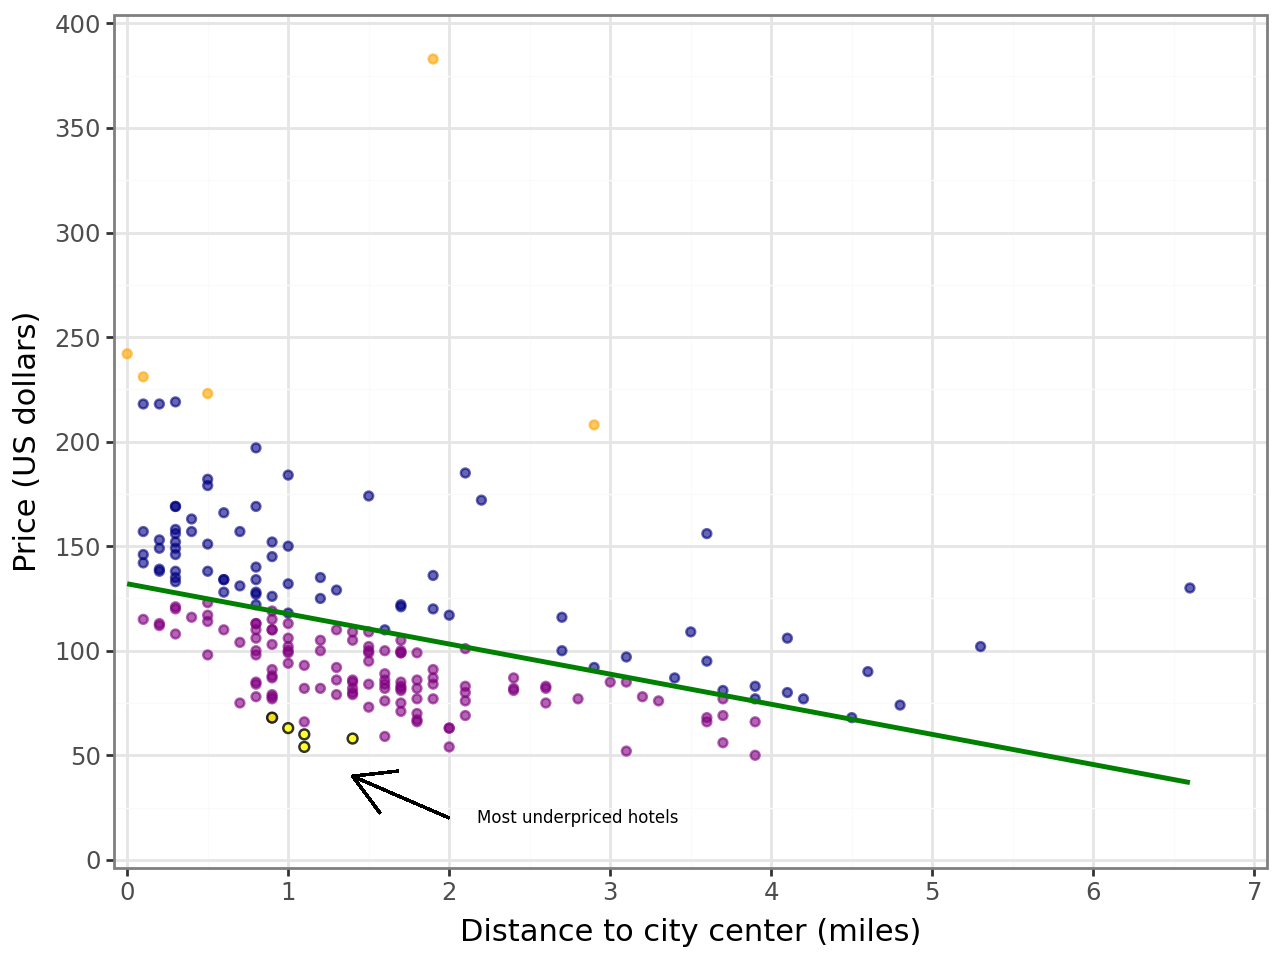

In [47]:
(
    ggplot(hotels, aes(x="distance", y="price"))
    + geom_point(
        hotels.loc[hotels["reg1_res"] == "overpriced"],
        aes(color="reg1_res"),
        size=1.3,
        alpha=0.6,
        show_legend=False,
    )
    + geom_point(
        hotels.loc[hotels["reg1_res"] == "underpriced"],
        aes(color="reg1_res"),
        size=1.3,
        alpha=0.6,
        show_legend=False,
    )
    + geom_point(
        hotels.loc[hotels["reg1_res"] == "bottom5"],
        aes(color="reg1_res", fill="reg1_res"),
        size=1.5,
        alpha=0.8,
        show_legend=False,
    )
    + geom_point(
        hotels.loc[hotels["reg1_res"] == "top5"],
        aes(color="reg1_res"),
        size=1.3,
        alpha=0.6,
        show_legend=False,
    )
    + geom_smooth(method="lm", size=1, color="green", se=False)
    + coord_cartesian(xlim=(0, 7), ylim=(0, 400))
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 8), breaks=np.arange(0, 8, 1))
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(0, 400), breaks=np.arange(0, 401, 50)
    )
    + labs(x="Distance to city center (miles)", y="Price (US dollars)")
    + scale_color_manual(name="", values=("navy", "purple", "black", "orange"))
    + scale_fill_manual(name="", values="yellow")
    + annotate("text", x=2.8, y=20, label="Most underpriced hotels", size=6)
    + geom_segment(aes(x=2, y=20, xend=1.4, yend=40), arrow=arrow())
    + theme_bw()
)


### Table 7.1

In [48]:
(
    hotels.loc[
        hotels["reg1_res"] == "bottom5",
        ["hotel_id", "distance", "price", "predprice", "e"],
    ]
    .sort_values(by=["e"])
    .round(2)
    .reset_index(drop=True)
    .rename({"e": "residual"}, axis=1)
)

,hotel_id,distance,price,predprice,residual
0,22080,1.1,54,116.17,-62.17
1,21912,1.1,60,116.17,-56.17
2,22152,1.0,63,117.61,-54.61
3,22408,1.4,58,111.85,-53.85
4,22165,0.9,68,119.05,-51.05


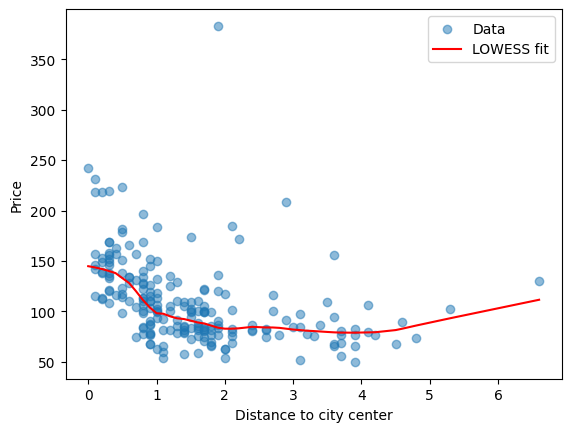

NameError: name 'dow' is not defined

In [49]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Define your x and y
x = hotels["distance"]
y = hotels["price"]

# Run LOWESS smoothing
lowess = sm.nonparametric.lowess
smoothed = lowess(y, x, frac=0.3)

# Plot the original data and the smoothed line
plt.scatter(x, y, alpha=0.5, label="Data")
plt.plot(smoothed[:, 0], smoothed[:, 1], color='red', label="LOWESS fit")
plt.xlabel("Distance to city center")
plt.ylabel("Price")
plt.legend()
plt.show()
dow